In [90]:
import simpy
import random
import statistics
from typing import List, Generator, Any
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
# -------------------------------------------------------------------------
# Execution example:
# python exercise1.py
# -------------------------------------------------------------------------

# Simulation Parameters (Constants)
RANDOM_SEED: int = 42
SIMULATION_TIME: float = 160  # Total simulation time in hours
MEAN_INTERARRIVAL: float = 2.0  # Mean interarrival time (hours)
INSPECTION_TIME_MIN: float = 0.25  # Minimum inspection duration (hours)
INSPECTION_TIME_MAX: float = 1.05  # Maximum inspection duration (hours)
REPAIR_TIME_MIN: float = 2.1  # Minimum repair duration (hours)
REPAIR_TIME_MAX: float = 4.5  # Maximum repair duration (hours)
REPAIR_PROB: float = 0.3  # Probability that a bus requires repair


def convert_hours_to_hms(hours: float) -> str:
    total_seconds = hours * 3600
    h = int(total_seconds // 3600)
    m = int((total_seconds % 3600) // 60)
    s = int(total_seconds % 60)
    return f"{h}h:{m}m:{s}s"


# Global lists for statistics
inspection_wait_times: List[float] = []  # Waiting times for inspection
repair_wait_times: List[float] = []  # Waiting times for repair
inspection_queue_lengths: List[int] = []  # Sampled lengths of the inspection queue
repair_queue_lengths: List[int] = []  # Sampled lengths of the repair queue


class InspectionStation:
    """
    Represents an inspection station with a single service resource.
    """

    def __init__(self, env: simpy.Environment) -> None:
        self.env: simpy.Environment = env
        self.resource: simpy.Resource = simpy.Resource(env, capacity=1)
        self.busy_time: float = 0.0  # Total time the station is occupied

    def inspect(self, bus_id: str) -> Generator[Any, None, None]:
        """
        Process for inspecting a bus.

        Args:
            bus_id (str): Identifier of the bus.

        Yields:
            simpy.Timeout: A timeout event representing the inspection duration.
        """
        service_time: float = random.uniform(INSPECTION_TIME_MIN, INSPECTION_TIME_MAX)
        yield self.env.timeout(service_time)
        self.busy_time += service_time


class RepairStation:
    """
    Represents a repair station with two service resources.
    """

    def __init__(self, env: simpy.Environment) -> None:
        self.env: simpy.Environment = env
        self.resource: simpy.Resource = simpy.Resource(env, capacity=2)
        self.busy_time: float = 0.0  # Combined busy time for both repair units

    def repair(self, bus_id: str) -> Generator[Any, None, None]:
        """
        Process for repairing a bus.

        Args:
            bus_id (str): Identifier of the bus.

        Yields:
            simpy.Timeout: A timeout event representing the repair duration.
        """
        service_time: float = random.uniform(REPAIR_TIME_MIN, REPAIR_TIME_MAX)
        yield self.env.timeout(service_time)
        self.busy_time += service_time


def bus(
    env: simpy.Environment,
    bus_id: str,
    inspection_station: InspectionStation,
    repair_station: RepairStation,
) -> Generator[Any, None, None]:
    """
    Process representing a bus undergoing inspection and, if necessary, repair.

    Args:
        env (simpy.Environment): The simulation environment.
        bus_id (str): Identifier for the bus.
        inspection_station (InspectionStation): The inspection station instance.
        repair_station (RepairStation): The repair station instance.

    Yields:
        Generator events from the inspection and, if needed, repair processes.
    """
    arrival_time: float = env.now

    # Inspection Phase
    with inspection_station.resource.request() as req:
        yield req
        wait_time: float = env.now - arrival_time
        inspection_wait_times.append(wait_time)
        yield env.process(inspection_station.inspect(bus_id))

    # Decide whether the bus needs repair based on probability
    if random.random() < REPAIR_PROB:
        repair_arrival_time: float = env.now
        with repair_station.resource.request() as req:
            yield req
            repair_wait: float = env.now - repair_arrival_time
            repair_wait_times.append(repair_wait)
            yield env.process(repair_station.repair(bus_id))


def bus_generator(
    env: simpy.Environment,
    inspection_station: InspectionStation,
    repair_station: RepairStation,
) -> Generator[Any, None, None]:
    """
    Generates buses at intervals following an exponential distribution.

    Args:
        env (simpy.Environment): The simulation environment.
        inspection_station (InspectionStation): The inspection station instance.
        repair_station (RepairStation): The repair station instance.

    Yields:
        Generator events representing bus arrival timeouts.
    """
    bus_count: int = 0
    while True:
        bus_count += 1
        env.process(bus(env, f"Bus {bus_count}", inspection_station, repair_station))
        interarrival_time: float = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)


def monitor_queues(
    env: simpy.Environment,
    inspection_station: InspectionStation,
    repair_station: RepairStation,
    sample_interval: float = 0.1,
) -> Generator[Any, None, None]:
    """
    Periodically samples the lengths of the inspection and repair queues.

    Args:
        env (simpy.Environment): The simulation environment.
        inspection_station (InspectionStation): The inspection station instance.
        repair_station (RepairStation): The repair station instance.
        sample_interval (float, optional): Time interval between samples. Defaults to 0.1.

    Yields:
        Generator events for sampling the queue lengths.
    """
    while True:
        inspection_queue_lengths.append(len(inspection_station.resource.queue))
        repair_queue_lengths.append(len(repair_station.resource.queue))
        yield env.timeout(sample_interval)


def calculate_statistics(
    inspection_wait_times: List[float],
    repair_wait_times: List[float],
    inspection_queue_lengths: List[int],
    repair_queue_lengths: List[int],
    inspection_station: InspectionStation,
    repair_station: RepairStation,
) -> dict:
    """
    Calculate and return various statistics from the simulation.
    Args:
        inspection_wait_times (List[float]): List of inspection wait times.
        repair_wait_times (List[float]): List of repair wait times.
        inspection_queue_lengths (List[int]): List of inspection queue lengths.
        repair_queue_lengths (List[int]): List of repair queue lengths.
        inspection_station (InspectionStation): The inspection station instance.
        repair_station (RepairStation): The repair station instance.
    Returns:
        dict: Dictionary containing calculated statistics.
    """

    avg_inspection_wait: float = (
        statistics.mean(inspection_wait_times) if inspection_wait_times else 0.0
    )
    avg_repair_wait: float = (
        statistics.mean(repair_wait_times) if repair_wait_times else 0.0
    )

    avg_inspection_queue: float = (
        statistics.mean(inspection_queue_lengths) if inspection_queue_lengths else 0.0
    )
    avg_repair_queue: float = (
        statistics.mean(repair_queue_lengths) if repair_queue_lengths else 0.0
    )

    utilization_inspection: float = inspection_station.busy_time / SIMULATION_TIME * 100
    utilization_repair: float = repair_station.busy_time / (2 * SIMULATION_TIME) * 100

    return {
        "avg_inspection_wait": avg_inspection_wait,
        "avg_repair_wait": avg_repair_wait,
        "avg_inspection_queue": avg_inspection_queue,
        "avg_repair_queue": avg_repair_queue,
        "utilization_inspection": utilization_inspection,
        "utilization_repair": utilization_repair,
    }

def report(stats: dict) -> None:
    """
    Print the simulation results.

    Args:
        stats (dict): Dictionary containing the statistics to report.
    """
    print(
        f"Average wait time for inspection: {convert_hours_to_hms(stats['avg_inspection_wait'])}"
    )
    print(
        f"Average wait time for repair: {convert_hours_to_hms(stats['avg_repair_wait'])}"
    )
    print(f"Average queue length at inspection: {stats['avg_inspection_queue']:.3f}")
    print(f"Average queue length at repair: {stats['avg_repair_queue']:.3f}")
    print(f"Average inspection station utilization: {stats['utilization_inspection']:.3f} %")
    print(f"Average repair station utilization: {stats['utilization_repair']:.3f} %")

def run_simulation() -> None:
    """
    Sets up and executes the simulation, then prints collected statistics.
    """
    random.seed(RANDOM_SEED)
    env: simpy.Environment = simpy.Environment()

    # Create service stations
    inspection_station: InspectionStation = InspectionStation(env)
    repair_station: RepairStation = RepairStation(env)

    # Initiate processes: bus arrivals and queue monitoring
    env.process(bus_generator(env, inspection_station, repair_station))
    env.process(monitor_queues(env, inspection_station, repair_station))
    env.run(until=SIMULATION_TIME)

    # Calculate statistics
    stats = calculate_statistics(
        inspection_wait_times,
        repair_wait_times,
        inspection_queue_lengths,
        repair_queue_lengths,
        inspection_station,
        repair_station,
    )

    return stats


In [92]:
results = []

for _ in range(100):
    RANDOM_SEED = random.randint(0, 1000)
    stats = run_simulation()
    results.append({
        "avg_inspection_wait": stats['avg_inspection_wait'],
        "avg_repair_wait": stats['avg_repair_wait'],
        "avg_inspection_queue": stats['avg_inspection_queue'],
        "avg_repair_queue": stats['avg_repair_queue'],
        "utilization_inspection": stats['utilization_inspection'],
        "utilization_repair": stats['utilization_repair'],
    })

df_results = pd.DataFrame(results)
mean_resuls = df_results.mean()
report(mean_resuls.to_dict())

Average wait time for inspection: 0h:9m:56s
Average wait time for repair: 0h:5m:23s
Average queue length at inspection: 0.085
Average queue length at repair: 0.013
Average inspection station utilization: 33.578 %
Average repair station utilization: 25.135 %


In [93]:
RANDOM_SEED = 42
mean_interarrival_values = [n/10 for n in range(20, 0, -1)] 

results = []

for m in mean_interarrival_values:
    MEAN_INTERARRIVAL = m
    stats = run_simulation()
    results.append({
        "mean_interarrival": m,
        "inspection_wait_times": stats['avg_inspection_wait'],
        "repair_wait_times": stats['avg_repair_wait'],
        "inspection_queue_lengths": stats['avg_inspection_queue'],
        "repair_queue_lengths": stats['avg_repair_queue'],
        "inspection_utilization": stats['utilization_inspection'],
        "repair_utilization": stats['utilization_repair'],
    })

df_results = pd.DataFrame(results)
df_results['arrival_rate'] = 1 / df_results['mean_interarrival']

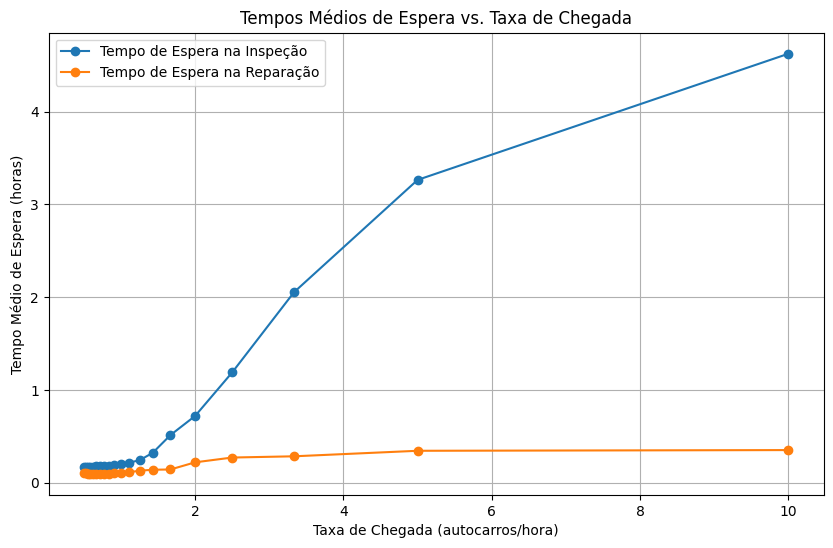

In [94]:
# --- Gráfico 1: Tempos Médios de Espera vs. Taxa de Chegada ---
plt.figure(figsize=(10, 6))
plt.plot(df_results['arrival_rate'], df_results['inspection_wait_times'], marker='o', label="Tempo de Espera na Inspeção")
plt.plot(df_results['arrival_rate'], df_results['repair_wait_times'], marker='o', label="Tempo de Espera na Reparação")
plt.xlabel("Taxa de Chegada (autocarros/hora)")
plt.ylabel("Tempo Médio de Espera (horas)")
plt.title("Tempos Médios de Espera vs. Taxa de Chegada")
plt.legend()
plt.grid(True)
plt.show()

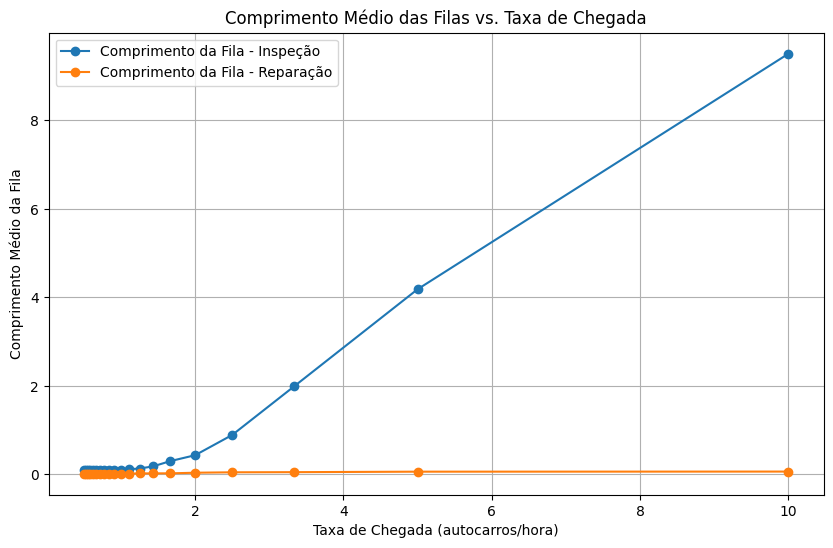

In [95]:
# --- Gráfico 2: Comprimento Médio das Filas vs. Taxa de Chegada ---
plt.figure(figsize=(10, 6))
plt.plot(df_results['arrival_rate'], df_results['inspection_queue_lengths'], marker='o', label="Comprimento da Fila - Inspeção")
plt.plot(df_results['arrival_rate'], df_results['repair_queue_lengths'], marker='o', label="Comprimento da Fila - Reparação")
plt.xlabel("Taxa de Chegada (autocarros/hora)")
plt.ylabel("Comprimento Médio da Fila")
plt.title("Comprimento Médio das Filas vs. Taxa de Chegada")
plt.legend()
plt.grid(True)
plt.show()

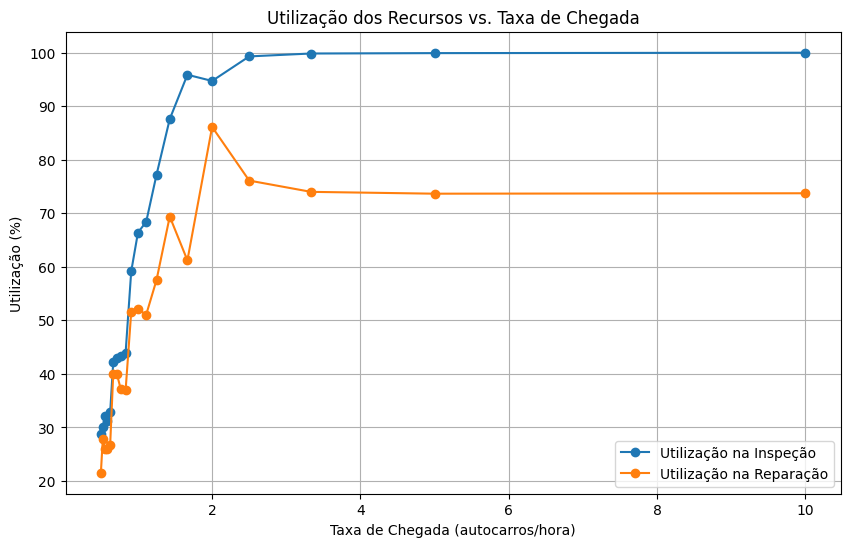

In [96]:
# --- Gráfico 3: Utilização dos Recursos vs. Taxa de Chegada ---
plt.figure(figsize=(10, 6))
plt.plot(df_results['arrival_rate'], df_results['inspection_utilization'], marker='o', label="Utilização na Inspeção")
plt.plot(df_results['arrival_rate'], df_results['repair_utilization'], marker='o', label="Utilização na Reparação")
plt.xlabel("Taxa de Chegada (autocarros/hora)")
plt.ylabel("Utilização (%)")
plt.title("Utilização dos Recursos vs. Taxa de Chegada")
plt.legend()
plt.grid(True)
plt.show()